In [1]:
# Utilities
from pathlib import Path
import os, sys
import subprocess as sp

# Data
import pandas as pd
import numpy as np

# Brain
import nibabel as nb
from nibabel.freesurfer.io import read_annot, read_label, read_morph_data, read_geometry
import cortex
import src.mesh_laplace_sulci

import gdist
import pygeodesic.geodesic as geodesic

# Plotting
from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt

from utility_funcs import mris_convert_command




## Desired functions

1. Get ROI: using four boundary sulci, get all faces and vertices within them  
2. Get centroid: find the centroid of a label
3. Get crowns: find the gyral crowns (or pits) within a label
4. Autosegment: surface simplification for data-driven segmentation of labels
5. Geodesic distance: geodesic distance AND path between sets of vertices

Idea for 1:
- Get boundary vertices  
- draw geodesic path among boundary vertices  
- Geodesic path among edges i.e. superior edge of anterior -> anterior edge of superior  
- being at superior of anterior, move one edge posterior and inferior  
- if target vertex is not in boundary vertices, add face to label  
- if target vertex is in boundary vertices, select other edge ~~ which edge? spiral through  
  - before adding check all three adjacent triangles  
  - plan to go to next triangle which has border with added vertex  

In [2]:
# filepath = '/Users/benparker/Desktop/cnl/subjects/100307/surf/lh.pial'

# mris_convert_command(filepath, custom_filename='mris_convert')

## Gdist

In [3]:
import os,sys
import os,sys
import nibabel as nib
from numpy import *
import gdist
#import surfdist as sd
import numpy as np


# NOTE: had trouble with numba format and jit in surfdist, so some functions are copied over with slight modifications below


def translate_src(src, cortex):
    """
    Convert source nodes to new surface (without medial wall).
    """
    src_new = np.array(np.where(np.in1d(cortex, src))[0], dtype=np.int32)

    return src_new


def triangles_keep_cortex(triangles, cortex):
    """
    Remove triangles with nodes not contained in the cortex label array
    """

    # for or each face/triangle keep only those that only contain nodes within the list of cortex nodes
    input_shape = triangles.shape
    triangle_is_in_cortex = np.all(np.reshape(np.in1d(triangles.ravel(), cortex), input_shape), axis=1)

    cortex_triangles_old = np.array(triangles[triangle_is_in_cortex], dtype=np.int32)

    # reassign node index before outputting triangles
    new_index = np.digitize(cortex_triangles_old.ravel(), cortex, right=True)
    cortex_triangles = np.array(np.arange(len(cortex))[new_index].reshape(cortex_triangles_old.shape), dtype=np.int32)

    return cortex_triangles


def surf_keep_cortex(surf, cortex):
    # split surface into vertices and triangles
    vertices, triangles = surf

    # keep only the vertices within the cortex label
    cortex_vertices = np.array(vertices[cortex], dtype='float64')

    # keep only the triangles within the cortex label
    cortex_triangles = triangles_keep_cortex(triangles, cortex)

    return cortex_vertices, cortex_triangles


def dist_calc_matrix(surf, cortex, label_inds_all):
    cortex_vertices, cortex_triangles = surf_keep_cortex(surf, cortex)
    
    n_labels = len(labels)
 
    dist_mat = zeros((n_labels,n_labels))

    
    for r1 in arange(n_labels):
        #print('r1',r1,label_inds_all[r1])
        for r2 in arange(n_labels):
            # print('r2',r2,label_inds_all[r2])
            # val1 = gdist.compute_gdist(cortex_vertices, cortex_triangles,
            #                                source_indices = array(label_inds_all[r1]))
            # print('val1',val1)
            # Uncomment next three lines for Suvi original gdist code
            print('Label inds r1:', label_inds_all[r1])
            
            # val2 = gdist.compute_gdist(cortex_vertices, cortex_triangles,
            #                                 source_indices = array(label_inds_all[r1]),
            #                                 target_indices = array(label_inds_all[r2]))
            
            
            #
            #
            ## TODO in order for this to work we need to select single index for the source and target
            ## Options: take center, take nearest

            val2 = geodesic.PyGeodesicAlgorithmExact(cortex_vertices, cortex_triangles)
            source_indices = find_centroid(cortex_vertices[label_inds_all[r1]])
            target_indices = find_centroid(cortex_vertices[label_inds_all[r2]])

            ## .geodesicDistances(array) gets distance amoung all indices provided in array
            ## .geodesicDistance(source, target) requires using single source index and single target index

            val2_distance, val2_path = val2.geodesicDistance(source_indices, target_indices)
            # val2_distance, val2_path = val2.geodesicDistances(label_inds_all[r1])

            #print('val2',val2)
            dist_mat[r1,r2] = amin(val2) #UNCOMMENT for original code
            # dist_mat[r1,r2] = amin(val2_distance)

    return dist_mat

def find_centroid(label_vertices):
    """
    Finds centroid position for a list of RAS vertices

    returns list = [R, A, S]
    """ 
    centroid = []
    for i in arange(3):
        sum_verts = np.sum(label_vertices[i,:])
        centroid_val = sum_verts / len(label_vertices)
        centroid.append(centroid_val)
    return centroid

def getLabelIndices(sub,hemi,labels,cortex, subjects_dir):
    label_inds_all = []
    
    n_labels = len(labels)
    
    
    print('Num labels:', n_labels)

    for lab in labels:
        if type(lab) is list: # pick the first label in list that exists
            label_found = False
            for inner_label in lab:
                labelfile = '%s/%s/label/%s.%s.label'%(subjects_dir,sub,hemi,inner_label)
                if os.path.exists(labelfile) and not label_found:
                    labelfile_use = labelfile
                    label_found = True
        else: # look for specific label
            labelfile_use = '%s/%s/label/%s.%s.label'%(subjects_dir,sub,hemi,lab)
        label_inds = nib.freesurfer.io.read_label(labelfile_use, read_scalars=False)
        label_inds_t = translate_src(label_inds,cortex) # exclude medial wall
        label_inds_all.append(label_inds_t)
        
    
    return label_inds_all


def getDistMatrix(subjects_dir=str, labels=list, sub=str, hemi=str, savedir=str, fmri_prep=False):
    """
    Outputs geodesic distances among all labels for a given sub/hemi
    """
    if fmri_prep == True:
        highres_surface = '%s/sub-%s/ses-%s/anat/sub-%s_ses-%s_hemi-%s_midthickness.surf.gii'%(subjects_dir,sub,sub[-1],sub,sub[-1],hemi[0].upper())
    if fmri_prep == False:
        highres_surface = f'{subjects_dir}/{sub}/surf/{hemi}.pial'
    
 
    giidata = nb.freesurfer.read_geometry(highres_surface)

   
    # giidata2 = np.squeeze(np.asarray([x for x in giidata])) 
    surf = (giidata[0],giidata[1])  

    
    if fmri_prep == True:
        cort_file = '%s/sub-%s/label/%s.cortex.label'%(os.environ['SUBJECTS_DIR'],sub,hemi)
    if fmri_prep == False:
       cort_file = f'{subjects_dir}/{sub}/label/{hemi}.cortex.label'
    
    cortex = sort(nb.freesurfer.read_label(cort_file))

    
    label_inds_all = getLabelIndices(sub,hemi,labels,cortex, subjects_dir)

    dist_matrix = dist_calc_matrix(surf,cortex,label_inds_all)
   

    savetxt('%s/adj-labels-%s.txt'%(savedir,hemi),dist_matrix)




In [4]:
path_obj = '/Users/benparker/Desktop/cnl/subjects/100307/label/lh.inflated'

In [5]:
os.path.dirname(path_obj)

'/Users/benparker/Desktop/cnl/subjects/100307/label'

In [10]:
subjects_dir = '/Users/benparker/Desktop/cnl/subjects'
labels = ['POS','MCGS']
sub = '100307'
hemi = 'lh'
outdir = '/Users/benparker/Desktop/cnl/CNL_scalpel/results'

#getDistMatrix(subjects_dir,labels,sub,hemi,outdir, fmri_prep=False)

In [19]:
highres_surface = f'{subjects_dir}/{sub}/surf/{hemi}.pial'
    
 
giidata = nb.freesurfer.read_geometry(highres_surface)
points, faces = giidata[0], giidata[1]

label_ind = nb.freesurfer.read_label('/Users/benparker/Desktop/cnl/subjects/100307/label/rh.MCGS.label')
label_points = points[label_ind]
label_faces = faces[label_ind]


In [32]:
unique_entry, count = np.unique(label_faces, return_counts=True)


In [41]:
face, count = np.unique(label_faces, return_counts=True)

In [77]:
np.where(label_faces, face[0])

ValueError: either both or neither of x and y should be given

In [45]:
""" 
for a set of triangular faces, if the vertex is a member of only 1 triangle
add face and vertex to boundary label
"""
edge = []
face, count = np.unique(label_faces, return_counts=True)

for idx in range(len(face)):
    if count[idx] == 1:
        edge_face = np.where(face[idx].isin())
        edge.append(face[idx])
    else:
        pass
    
    

In [66]:
label_points

array([[-50.27859497, -29.66693306, -39.71871948],
       [-46.83463669, -30.09557915, -40.86487961],
       [-20.86884499, -25.060112  ,  37.2919693 ],
       ...,
       [-17.64050293,  70.79608917, -19.83910942],
       [-20.50230789,  70.97837067, -19.1332016 ],
       [-27.79295731,  69.3931427 , -18.81979752]])

In [50]:
faces[edge]

537

array([[-50.27859497, -29.66693306, -39.71871948],
       [-46.83463669, -30.09557915, -40.86487961],
       [-20.86884499, -25.060112  ,  37.2919693 ],
       ...,
       [-17.64050293,  70.79608917, -19.83910942],
       [-20.50230789,  70.97837067, -19.1332016 ],
       [-27.79295731,  69.3931427 , -18.81979752]])

In [14]:
label_annot = nb.freesurfer.read_annot('/Users/benparker/Desktop/cnl/subjects/100307/label/lh.PFC_annot.annot')

for id in np.unique(label_annot[0]):
    print('id = %d, sum = %d'%(id, (label_annot[0] == id).sum()))

id = -1, sum = 118706
id = 0, sum = 3643
id = 1, sum = 1131
id = 2, sum = 831
id = 3, sum = 832
id = 4, sum = 1639
id = 5, sum = 772
id = 6, sum = 397
id = 7, sum = 535
id = 8, sum = 1444
id = 9, sum = 698
id = 10, sum = 251


In [16]:


geoalg = geodesic.PyGeodesicAlgorithmExact(points, faces)
sourceIndex = 25
targetIndex = 97
# Compute the geodesic distance and the path
distance, path = geoalg.geodesicDistance(sourceIndex, targetIndex)
path

array([[ -1.35481012, -76.9079895 , -11.9917984 ],
       [ -1.8057055 , -77.16084878, -12.15658785],
       [ -2.42826358, -77.44982389, -12.38781169],
       [ -2.59597011, -77.52264554, -12.45038318],
       [ -2.73134925, -77.57722628, -12.50106535],
       [ -3.34306614, -77.79669552, -12.7320138 ],
       [ -3.7647475 , -77.88611146, -12.89647065],
       [ -4.05438525, -77.93750909, -13.01024463],
       [ -4.35890905, -77.98404561, -13.13057137],
       [ -4.76563425, -78.02666812, -13.29281327],
       [ -5.27875079, -78.0546205 , -13.49930141],
       [ -5.5109015 , -78.05079138, -13.59323869],
       [ -5.65983488, -78.07304257, -13.65324915],
       [ -6.43935061, -78.11183167, -13.97138786]])

## Find boundary

In [25]:



def read_label(label_name):
    """
    Reads a freesurfer-style .label file (5 columns)
    
    Parameters
    ----------
    label_name: str 
    
    Returns 
    -------
    vertices: index of the vertex in the label np.array [n_vertices] 
    RAS_coords: columns are the X,Y,Z RAS coords associated with vertex number in the label, np.array [n_vertices, 3] 
    
    """
    
    # read label file, excluding first two lines of descriptor 
    df_label = pd.read_csv(label_name,skiprows=[0,1],header=None,names=['vertex','x_ras','y_ras','z_ras','stat'],delimiter='\s+')
    
    vertices = np.array(df_label.vertex) 
    RAS_coords = np.empty(shape = (vertices.shape[0], 3))
    RAS_coords[:,0] = df_label.x_ras
    RAS_coords[:,1] = df_label.y_ras
    RAS_coords[:,2] = df_label.z_ras
    
    return vertices, RAS_coords



In [26]:
## Load labels for boundary sulci


vertices, coords = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')
label_MCGS = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')

r_data = np.array([ras[0] for ras in coords])
a_data = np.array([ras[1] for ras in coords])
s_data = np.array([ras[2] for ras in coords])




In [27]:
def find_inferior_boundary(read_label, outlier_corrected=True, decimal_size=1, outlier_std_threshold=3):
    """
    Finds vertices along inferior boundary of given Freesurfer label.

    Bins all vertices along anterior axis, effecitvly getting every vertex in a coronal slice rounded to the decimal_size,
    and returns coordinates with the lowest Superior axis value in that column.

    INPUT:
    read_label = list [vertices, coordinates] : as outputed from read_label
    outlier_corrected = boolean; if True removes all vertices if S value is outside of 3 SDs of mean
    decimal_size = int; determines size of rounding done to bin anterior vertices, 1 is suggested
    outlier_std_threshold= int; allows change of SD multiple for outlier correction

    OUTPUT:
    inferior_boundary_vertex_num = np array; vertex number for each minimum Superior value along anterior axis
    inferior_boundary_coords = np array; RAS coordinates for each minimum Superior value along anterior axis


    Example:

    output_vertex_number, output_vertex_coords = find_inferior_boundary(read_label('home/subjects/100307/label/lh.MCGS.label'))


    """
  
    vertex_num = read_label[0]
    ras_coords = read_label[1]

    
    r_data = np.array([ras[0] for ras in ras_coords])
    a_data = np.array([ras[1] for ras in ras_coords])
    s_data = np.array([ras[2] for ras in ras_coords])

    inferior_boundary_coords = []
    inferior_boundary_vertex_num = []
    rounded_anterior = np.round(a_data, decimals=decimal_size)

  # for each rounded A value, find the vertex with the lowest S value
  # add vertex to inferior boundary
    for anterior in np.unique(rounded_anterior):
      # get all vertices with shared A coordinate
      column_idx = np.where(rounded_anterior == anterior)[0]
      # find minimum S coordinate from that column of points
      min_val = np.amin(s_data[column_idx])
      # be sure idx is drawn from original column idxes
      all_min_idx = np.where(s_data == min_val)[0]
      column_min_idx = np.intersect1d(all_min_idx, column_idx)
      # add inferior boundary and vertex to list

      inferior_boundary_coords.append(list(ras_coords[column_min_idx][0]))
      inferior_boundary_vertex_num.append(vertex_num[column_min_idx][0])

    mean_boundary_coord = np.mean([i[2] for i in inferior_boundary_coords])
    std_boundary_coord = np.std([i[2] for i in inferior_boundary_coords])
    
    # Keep coordinate if S coordinate is within 3 stds of mean 
    if outlier_corrected == True:
      inferior_boundary_coords_outlier = []
      inferior_boundary_vertex_num_outlier = []
      for i, coord_vert in enumerate(inferior_boundary_coords):
          if coord_vert[2] > (mean_boundary_coord - decimal_size * std_boundary_coord) and coord_vert[2] < (mean_boundary_coord + decimal_size * std_boundary_coord): 
            inferior_boundary_coords_outlier.append(inferior_boundary_coords[i])
            inferior_boundary_vertex_num_outlier.append(inferior_boundary_vertex_num[i])
          else:
            pass
      return np.array(inferior_boundary_vertex_num_outlier), np.array(inferior_boundary_coords_outlier)
    else: 
      pass
#     for vertex in ras_coords:
      return np.array(inferior_boundary_vertex_num), np.array(inferior_boundary_coords)


vert_num, verts = find_inferior_boundary([vertices, coords], outlier_corrected=False, decimal_size=1)

r_data_min_inferior = np.array([ras[0] for ras in verts])
a_data_min_inferior = np.array([ras[1] for ras in verts])
s_data_min_inferior = np.array([ras[2] for ras in verts])



In [28]:
def find_posterior_boundary(read_label, outlier_corrected=True, decimal_size=1, outlier_std_threshold=3):
    """
    Finds vertices along posterior boundary of given Freesurfer label.

    Bins all vertices along superior axis, effecitvly getting every vertex in a horizontal slice rounded to the decimal_size,
    and returns coordinates with the lowest superior axis value in that column.

    INPUT:
    read_label = list [vertices, coordinates] : as outputed from read_label
    outlier_corrected = boolean; if True removes all vertices if S value is outside of 3 SDs of mean
    decimal_size = int; determines size of rounding done to bin superior vertices, 1 is suggested
    outlier_std_threshold= int; allows change of SD multiple for outlier correction

    OUTPUT:
    posterior_boundary_vertex_num = np array; vertex number for each minimum Superior value along superior axis
    posterior_boundary_coords = np array; RAS coordinates for each minimum Superior value along superior axis


    Example:

    output_vertex_number, output_vertex_coords = find_posterior_boundary(read_label('home/subjects/100307/label/lh.MCGS.label'))


    """
  
    vertex_num = read_label[0]
    ras_coords = read_label[1]

    
    r_data = np.array([ras[0] for ras in ras_coords])
    a_data = np.array([ras[1] for ras in ras_coords])
    s_data = np.array([ras[2] for ras in ras_coords])

    posterior_boundary_coords = []
    posterior_boundary_vertex_num = []
    rounded_superior = np.round(s_data, decimals=decimal_size)

  # for each rounded A value, find the vertex with the lowest S value
  # add vertex to posterior boundary
    for superior in np.unique(rounded_superior):
      # get all vertices with shared A coordinate
      column_idx = np.where(rounded_superior == superior)[0]
      # find minimum S coordinate from that column of points
      min_val = np.amin(s_data[column_idx])
      # be sure idx is drawn from original column idxes
      all_min_idx = np.where(s_data == min_val)[0]
      column_min_idx = np.intersect1d(all_min_idx, column_idx)
      # add posterior boundary and vertex to list

      posterior_boundary_coords.append(list(ras_coords[column_min_idx][0]))
      posterior_boundary_vertex_num.append(vertex_num[column_min_idx][0])
      

    mean_boundary_coord = np.mean([i[1] for i in posterior_boundary_coords])
    std_boundary_coord = np.std([i[1] for i in posterior_boundary_coords])
    
    # Keep coordinate if S coordinate is within 3 stds of mean 
    if outlier_corrected == True:
      posterior_boundary_coords_outlier = []
      posterior_boundary_vertex_num_outlier = []
      for i, coord_vert in enumerate(posterior_boundary_coords):
          if coord_vert[1] > (mean_boundary_coord - decimal_size * std_boundary_coord) and coord_vert[1] < (mean_boundary_coord + decimal_size * std_boundary_coord): 
            posterior_boundary_coords_outlier.append(posterior_boundary_coords[i])
            posterior_boundary_vertex_num_outlier.append(posterior_boundary_vertex_num[i])
          else:
            pass
      return np.array(posterior_boundary_vertex_num_outlier), np.array(posterior_boundary_coords_outlier)
    else: 
      pass
#     for vertex in ras_coords:
      return np.array(posterior_boundary_vertex_num), np.array(posterior_boundary_coords)



In [29]:
vert_num, verts = find_posterior_boundary([vertices, coords], outlier_corrected=True, decimal_size=1)

r_data_min_posterior = np.array([ras[0] for ras in verts])
a_data_min_posterior = np.array([ras[1] for ras in verts])
s_data_min_posterior = np.array([ras[2] for ras in verts])

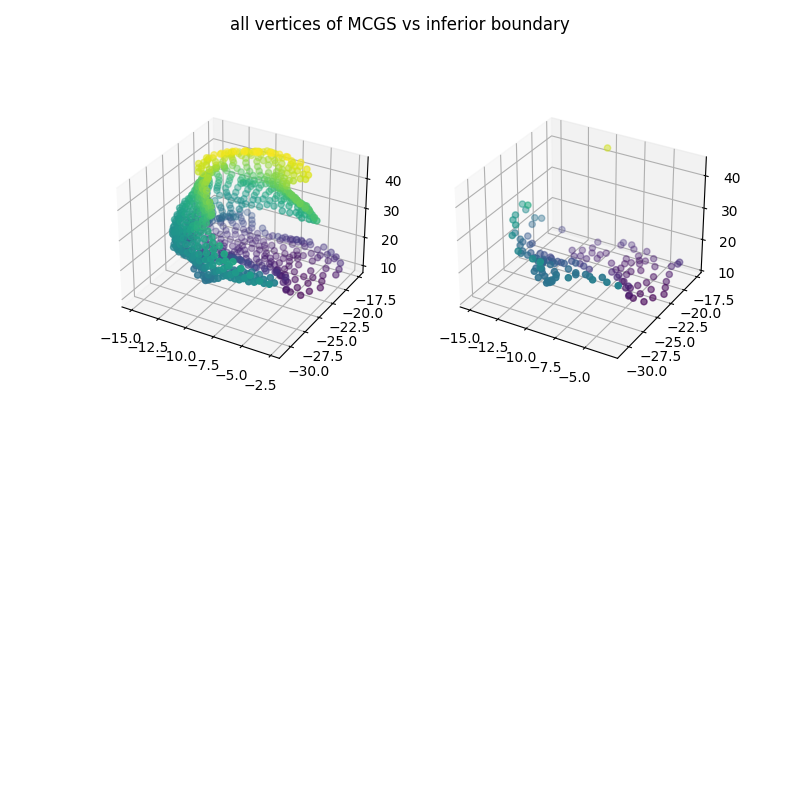

In [30]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax1.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# Getting lower bound of the sulcus

ax2.scatter3D(r_data_min_inferior, a_data_min_inferior, s_data_min_inferior, cmap='viridis', c=s_data_min_inferior, vmin=10, vmax=45)
ax2.set(zlim3d=[10,45]);
plt.suptitle('all vertices of MCGS vs inferior boundary')
plt.show();


# ax3 = fig.add_subplot(223, projection='3d')
# ax4 = fig.add_subplot(224, projection='3d')
# ax3.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# # Getting lower bound of the sulcus

# ax4.scatter3D(r_data_min_posterior, a_data_min_posterior, s_data_min_posterior, cmap='viridis', c=s_data_min_posterior, vmin=10, vmax=45)
# ax4.set(zlim3d=[10,45])
# plt.suptitle('all vertices of MCGS vs boundary vertices')
# fig.show();


In [31]:
def find_boundary_vertices(boundary, read_label, outlier_corrected=True, decimal_size=1, outlier_std_threshold=3):
    """
    Finds vertices along posterior boundary of given Freesurfer label.

    Bins all vertices along boundary axis, effecitvly getting every vertex in a horizontal slice rounded to the decimal_size,
    and returns coordinates with the lowest superior axis value in that column.

    INPUT:
    read_label = list [vertices, coordinates] : as outputed from read_label
    outlier_corrected = boolean; if True removes all vertices if S value is outside of 3 SDs of mean
    decimal_size = int; determines size of rounding done to bin superior vertices, 1 is suggested
    outlier_std_threshold= int; allows change of SD multiple for outlier correction

    OUTPUT:
    posterior_boundary_vertex_num = np array; vertex number for each minimum Superior value along superior axis
    posterior_boundary_coords = np array; RAS coordinates for each minimum Superior value along superior axis


    Example:

    output_vertex_number, output_vertex_coords = find_posterior_boundary(read_label('home/subjects/100307/label/lh.MCGS.label'))


    """
    if boundary == 'anterior' or boundary == 'posterior':
      # orthogonal measure index is the index along which we are trying to find min values i.e. A for S
      # finding minimum values on boundary axis along orthogonal axis
      measure_idx = 1
      orthogonal_measure_idx = 2

    if boundary == 'inferior' or boundary == 'superior':
      measure_idx = 2
      orthogonal_measure_idx = 1
    

    vertex_num = read_label[0]
    ras_coords = read_label[1]

    r_data = np.array([ras[0] for ras in ras_coords])
    a_data = np.array([ras[1] for ras in ras_coords])
    s_data = np.array([ras[2] for ras in ras_coords])
    
    all_data = [r_data, a_data, s_data]
    measure_data = all_data[measure_idx]
    orthogonal_data = all_data[orthogonal_measure_idx]
    
    
    boundary_coords = []
    boundary_vertex_num = []
    rounded_orthogonal = np.round(orthogonal_data, decimals=decimal_size)

  # for each rounded A value, find the vertex with the lowest S value
  # add vertex to posterior boundary

    for orthogonal_edge in np.unique(rounded_orthogonal):
      # get all vertices with shared orthogonal coordinate
      column_idx = np.where(rounded_orthogonal == orthogonal_edge)[0]

      # find minimum coordinate from that column of points
      if boundary == 'anterior' or boundary == 'inferior':
        min_val = np.amin(measure_data[column_idx])
        # be sure idx is drawn from original column idxes
        all_min_idx = np.where(measure_data == min_val)[0]
        column_min_idx = np.intersect1d(all_min_idx, column_idx)
        # add boundary and vertex to list
        boundary_coords.append(list(ras_coords[column_min_idx][0]))
        boundary_vertex_num.append(vertex_num[column_min_idx][0])
        
      else:
        max_val = np.amax(measure_data[column_idx])
        # be sure idx is drawn from original column idxes
        all_max_idx = np.where(measure_data == max_val)[0]
        column_max_idx = np.intersect1d(all_max_idx, column_idx)
        # add posterior boundary and vertex to list
        boundary_coords.append(list(ras_coords[column_max_idx][0]))
        boundary_vertex_num.append(vertex_num[column_max_idx][0])
      

    mean_boundary_coord = np.mean([i[measure_idx] for i in boundary_coords])
    std_boundary_coord = np.std([i[measure_idx] for i in boundary_coords])
    
    # Keep coordinate if coordinate is within 3 stds of mean 
    if outlier_corrected == True:
      boundary_coords_outlier = []
      boundary_vertex_num_outlier = []
      for i, coord_vert in enumerate(boundary_coords):
          if coord_vert[measure_idx] > (mean_boundary_coord - decimal_size * std_boundary_coord) and coord_vert[measure_idx] < (mean_boundary_coord + decimal_size * std_boundary_coord): 
            boundary_coords_outlier.append(boundary_coords[i])
            boundary_vertex_num_outlier.append(boundary_vertex_num[i])
          else:
            pass
      return np.array(boundary_vertex_num_outlier), np.array(boundary_coords_outlier)
    else: 
      pass
#     for vertex in ras_coords:
      return np.array(boundary_vertex_num), np.array(boundary_coords)



In [32]:
test_vert_num, test_verts = find_boundary_vertices(boundary='anterior', read_label=label_MCGS, outlier_corrected=True, decimal_size=1)

test_r_data_min_inferior = np.array([ras[0] for ras in test_verts])
test_a_data_min_inferior = np.array([ras[1] for ras in test_verts])
test_s_data_min_inferior = np.array([ras[2] for ras in test_verts])



Text(0.5, 0.98, 'all vertices of MCGS vs anterior boundary')

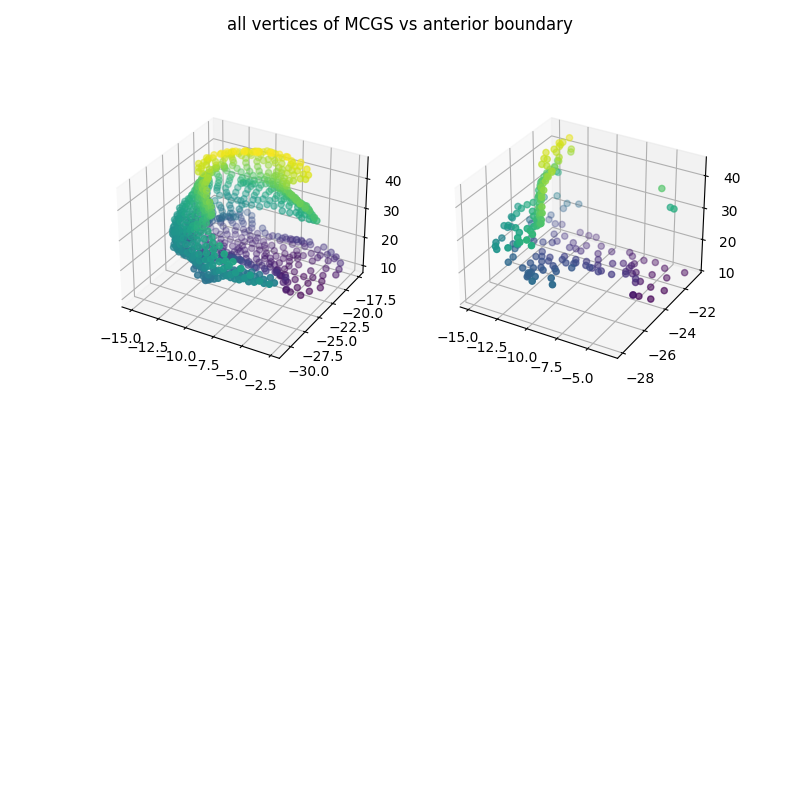

In [33]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax1.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# Getting lower bound of the sulcus

ax2.scatter3D(test_r_data_min_inferior, test_a_data_min_inferior, test_s_data_min_inferior, cmap='viridis', c=test_s_data_min_inferior, vmin=10, vmax=45)
ax2.set(zlim3d=[10,45]);
plt.suptitle('all vertices of MCGS vs anterior boundary')

## Surfaces and cutting

In [39]:
test_sub = ScalpelSurface(subject_filepath='~/Desktop/cnl/subjects/100307')

In [40]:
test_sub.make_ROI_cut(anterior_label='MCGS', posterior_label='POS', inferior_label='2', superior_label='MCGS', hemi='lh')
        

{'anterior': [array([42957, 41937, 44038, 42958, 45085, 41938, 44018, 42932, 44019,
       41911, 40923, 44001, 41912, 42916, 40908, 42917, 43987, 42900,
       41865, 41864, 42902, 42879, 43991, 42903, 42880, 43974, 42882,
       41839, 42883, 41838, 43975, 41840, 41841, 41843, 42863, 42864,
       41808, 42865, 41810, 41813, 40853, 40852, 42852, 41783, 41784,
       43955, 42853, 41788, 40824, 40827, 40825, 40826, 43945, 40801,
       41766, 40802, 40800, 40798, 40799, 40770, 40771, 39791, 39771,
       40769, 41750, 39772, 43936, 39773, 39750, 39749, 41737, 39751,
       43925, 39748, 38838, 38837, 38836, 42824, 38815, 38814, 38789,
       37846, 37845, 38788, 39730, 43912, 38791, 37824, 39708, 37823,
       41711, 38765, 37799, 44979, 37800, 39692, 43893, 40671, 43869,
       38709, 38710, 42733, 38702, 37722, 39651, 36793, 37710, 39645,
       38685, 40615, 38677, 36771, 39635, 38671, 38670, 40610, 37686,
       38669, 43787, 40602, 38666, 43780, 37681, 42685, 37682, 39621,
      

In [65]:
len(points)

130879

In [62]:
edge_index = 

[18428,
 18432,
 18444,
 18445,
 18968,
 18971,
 18974,
 18979,
 18981,
 18993,
 18997,
 19004,
 19007,
 19008,
 19481,
 19482,
 19536,
 19539,
 19540,
 19546,
 19549,
 19551,
 19557,
 19561,
 19961,
 19965,
 19967,
 19968,
 20098,
 20105,
 20106,
 20117,
 20118,
 20119,
 20121,
 20124,
 20127,
 20132,
 20133,
 20141,
 20142,
 20143,
 20155,
 20171,
 20172,
 20181,
 20186,
 20189,
 20190,
 20192,
 20193,
 20527,
 20533,
 20534,
 20537,
 20541,
 20547,
 20548,
 20551,
 20554,
 20559,
 20580,
 20613,
 20615,
 20617,
 20623,
 20632,
 20636,
 20637,
 20639,
 20642,
 20645,
 20649,
 20653,
 20665,
 20669,
 20673,
 20678,
 20679,
 20687,
 20688,
 20693,
 20695,
 20696,
 20698,
 20710,
 21068,
 21081,
 21086,
 21087,
 21089,
 21107,
 21112,
 21113,
 21114,
 21117,
 21118,
 21122,
 21124,
 21125,
 21128,
 21130,
 21134,
 21136,
 21140,
 21141,
 21143,
 21151,
 21152,
 21153,
 21157,
 21160,
 21166,
 21171,
 21173,
 21177,
 21178,
 21185,
 21186,
 21187,
 21189,
 21191,
 21197,
 21203,
 21207,


In [67]:
test_r_data_min_inferior = np.array([ras[0] for ras in label_points[edge]])
test_a_data_min_inferior = np.array([ras[1] for ras in label_points[edge]])
test_s_data_min_inferior = np.array([ras[2] for ras in label_points[edge]])



IndexError: index 18428 is out of bounds for axis 0 with size 625

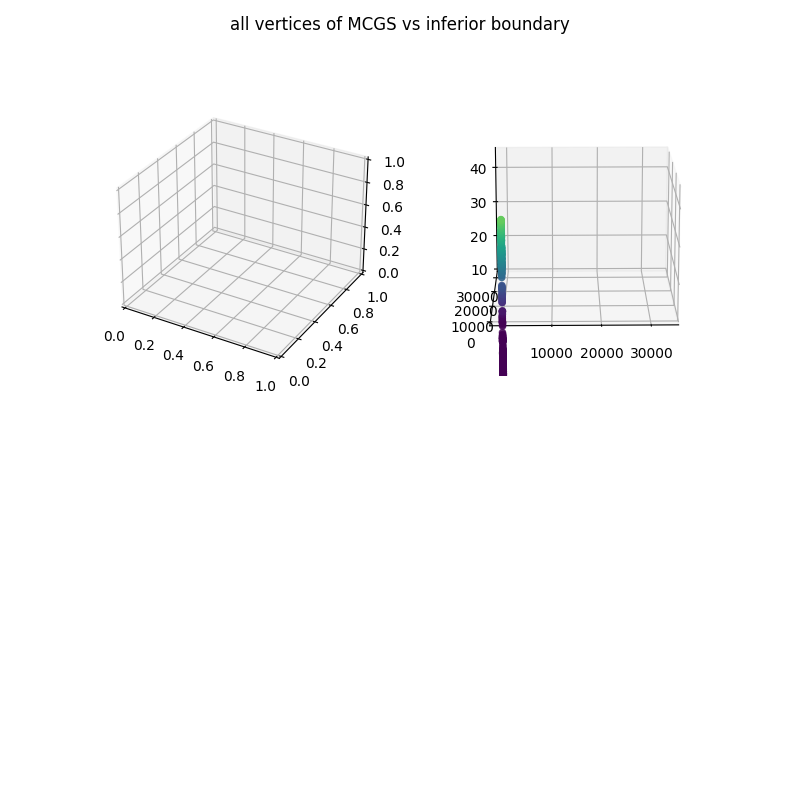

In [61]:

# Getting lower bound of the sulcus

ax2.scatter3D(test_r_data_min_inferior, test_a_data_min_inferior, test_s_data_min_inferior, cmap='viridis', c=test_s_data_min_inferior, vmin=10, vmax=45)

plt.suptitle('all vertices of MCGS vs inferior boundary')
plt.show();

## Class Definition

In [37]:
# Use boundary sulci to capture all vertices in surface between boundaries, and plot
import functools
from utility_funcs import memoize

class ScalpelSurface:
    """
    Surface class for performing scalpel operations

    REQUIREMENTS:
        - Freesurfer recon-all on subject
        - subject_filepath to subject freesurfer directory

    INPUT:
        - subject_filepath to subject freesurfer directory

    METHODS:
        cortex: list; [lh, rh], each is the result of nibabel.freesurfer.io.read_label on ?h.cortex.label i.e. [vertex_num, [R, A, S] for all vertices in hemisphere]
        make_roi_cut:  input - hemisphere, anterior, posterion, inferior, superior label names
                       output - freesurfer .label file including all vertices within bounded ROI

        get_boundary:  input - hemisphere=str, anterior=str, posterior=str, inferior=str, superior=str 
                       output - dict of boundary vertex numbers and vertex coordinates

        plot_boundary: input - label_name=str, label_filepath=str, outlier_corrected=bool, boundary_type=str, decimal_size=int 
                       output - 3D plots boundary vertices alongside vertices for whole label

    """
    def  __init__(self, subject_filepath= str):
        self._subject_filepath = Path(subject_filepath)
        

    @property
    @memoize
    def subject_filepath(self):
        return self._subject_filepath

    @subject_filepath.setter    
    def subject_filepath(self, value):
        print(f'"{self.subject_filepath}" is now "{value}"')
        self.subject_filepath = value

    @property
    @memoize
    def cortex(self):
        """
        Whole brain as a list with two elements, [lh, rh]
        each hemi is an array with two elements, [vertex_index, RAS_coords]
        """
        cortex = [read_label(self._subject_filepath / 'label/lh.cortex.label'), # lh.cortex.label
                  read_label(self._subject_filepath / 'label/rh.cortex.label')] # rh.cortex.label
        
        return cortex
    
    @cortex.setter
    def cortex(self, value):
        __subject_filepath = Path(value)
        cortex = [read_label(self._subject_filepath / 'label/lh.cortex.label'), # lh.cortex.label
                  read_label(self._subject_filepath / 'label/rh.cortex.label')] # rh.cortex.label
        return cortex
    
    


    def get_surface(self, surface_type, hemi):
        """Reads morph data on hemi.surface_type"""
        return read_morph_data(self.subject_filepath / f'surf/{hemi}.{surface_type}')
        
    
    def get_boundary(self, hemi, anterior_label, posterior_label, inferior_label, superior_label):
        """ 
        Gets edge of labels along anterior, posterior, inferior, superior labels

        Returns dictionary of {direction : [RAS_coordinates, vertex_number] 
        """
        anterior_boundary_vertices, anterior_boundary_vertex_num = find_boundary_vertices(subject_filepath=self._subject_filepath, hemi=hemi, boundary_type='anterior', label_name=anterior_label, outlier_corrected=True, decimal_size=1)
        posterior_boundary_vertices, posterior_boundary_vertex_num = find_boundary_vertices(subject_filepath=self._subject_filepath, hemi=hemi, boundary_type='posterior', label_name=posterior_label, outlier_corrected=True, decimal_size=1)
        inferior_boundary_vertices, inferior_boundary_vertex_num = find_boundary_vertices(subject_filepath=self._subject_filepath, hemi=hemi, boundary_type='inferior', label_name=inferior_label, outlier_corrected=True, decimal_size=1)
        superior_boundary_vertices, superior_boundary_vertex_num = find_boundary_vertices(subject_filepath=self._subject_filepath, hemi=hemi, boundary_type='superior', label_name=superior_label, outlier_corrected=True, decimal_size=1)

        boundary_dict = {'anterior' : [anterior_boundary_vertices, anterior_boundary_vertex_num],
                         'posterior' : [posterior_boundary_vertices, posterior_boundary_vertex_num],
                         'inferior' : [inferior_boundary_vertices, inferior_boundary_vertex_num ],
                         'superior' : [superior_boundary_vertices, superior_boundary_vertex_num]}
        edge_points = {'anterior_lh' : [np.min, np.max], 'anterior_rh': [np.min, np.max], 
                       'posterior_lh' :  } ## TODO finish iding edge points and then get geodesic paths among them
        
        # ID hemi
        if hemi == 'lh':
            hemi_ind = 0
        else:
            hemi_ind = 1

        # geodesic line drawn between vertices
        geoalg = geodesic.PyGeodesicAlgorithmExact(self.cortex[hemi_ind])


        return boundary_dict
    
    def make_ROI_cut(self, anterior_label, posterior_label, inferior_label, superior_label, ROI_name='', hemi=''):
        # Makes label of entire ROI between boundary vertices
        boundary_verts = self.get_boundary(hemi=hemi, anterior_label=anterior_label, posterior_label=posterior_label, inferior_label=inferior_label, superior_label=superior_label)
        
        for i, key in enumerate(boundary_verts.keys()):
            direction_sets = boundary_verts[key]
            


        # Gets rounded bins for each axis
        rounded_anterior = np.round(boundary_verts['anterior'][1][:, 1], decimals=1)
        rounded_posterior = np.round(boundary_verts['posterior'][1][:, 1], decimals=1)
        rounded_inferior = np.round(boundary_verts['inferior'][1][:, 2], decimals=1)
        rounded_superior = np.round(boundary_verts['superior'][1][:, 2], decimals=1)
        print(boundary_verts)

        cut_roi_coords  = []
        cut_roi_vert_idx = []
        # get vertex indices for all within ROI
        for hemi in self.cortex:
            hemi_cortex_idx = hemi[0]
            hemi_cortex_coords = hemi[1]
            for point in hemi_cortex_coords:
                point_rounded_ant_post = np.round(point[1], decimals=1)
                point_rounded_inf_sup = np.round(point[2], decimals=1)
                # find nearest point in rounded array
                

                # add all points within boundaries to cut_roi lists

                # draw geodesic path
                



        

    def plot_boundary(self, label_name='label', label_filepath='', outlier_corrected_bool=True, boundary_type='anterior', decimal_size=1):
        # Plot boundary versus original label
        vertices, coords = read_label(label_filepath)
        
        r_data = np.array([ras[0] for ras in coords])
        a_data = np.array([ras[1] for ras in coords])
        s_data = np.array([ras[2] for ras in coords])

        boundary_vert_num, boundary_verts = find_boundary_vertices(boundary=boundary_type, label_name=[vertices, coords], outlier_corrected=outlier_corrected_bool, decimal_size=decimal_size)

        boundary_r_data = np.array([ras[0] for ras in boundary_verts])
        boundary_a_data = np.array([ras[1] for ras in boundary_verts])
        boundary_s_data = np.array([ras[2] for ras in boundary_verts])

        fig = plt.figure(figsize=(8,8))
        ax1 = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')
        ax1.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

        # Getting lower bound of the sulcus

        ax2.scatter3D(boundary_r_data, boundary_a_data, boundary_s_data, cmap='viridis', c=boundary_s_data, vmin=10, vmax=45)
        ax2.set(zlim3d=[10,45]);
        plt.suptitle(f'all vertices of {label_name} vs {boundary_type} boundary')
        plt.show;





In [38]:

def get_vertex_idx():
  """
  Gets vertex index for coordinate
  """
  


def find_boundary_vertices(subject_filepath, hemi, label_name, boundary_type, outlier_corrected=True, decimal_size=1, outlier_std_threshold=3):
    """
    Finds vertices along boundary of given Freesurfer label, as identified by boundary_type.

    Bins all vertices along boundary axis, effectively getting every vertex in a slice rounded to the decimal_size,
    and returns coordinates and vertex numbers with the minimum or maximum axis value as specified by boundary type.

    INPUT:
    label_name = string : as it appears in /label/ freesurfer directory ie MCGS for lh.MCGS.label
    outlier_corrected = boolean; if True removes all vertices if S value is outside of 3 SDs of mean
    decimal_size = int; determines size of rounding done to bin superior vertices, 1 is suggested
    outlier_std_threshold= int; allows change of SD multiple for outlier correction

    OUTPUT:
    boundary_vertex_num = np array; vertex number for each minimum Superior value along superior axis
    boundary_coords = np array; RAS coordinates for each minimum Superior value along superior axis


    Example:

    output_vertex_number, output_vertex_coords = find_boundary_vertices(subject_filepath='~/subjects/100206/', hemi='lh', label_name='MCGS', boundary_type='anterior')


    """
    if boundary_type == 'anterior' or boundary_type == 'posterior':
      # orthogonal measure index is the index along which we are trying to find min values i.e. A for S
      # finding minimum values on boundary_type axis along orthogonal axis
      measure_idx = 1
      orthogonal_measure_idx = 2

    if boundary_type == 'inferior' or boundary_type == 'superior':
      measure_idx = 2
      orthogonal_measure_idx = 1
    
    label_data = read_label(subject_filepath / f"label/{hemi}.{label_name}.label")

    vertex_num = label_data[0]
    ras_coords = label_data[1]

    r_data = np.array([ras[0] for ras in ras_coords])
    a_data = np.array([ras[1] for ras in ras_coords])
    s_data = np.array([ras[2] for ras in ras_coords])
    
    all_data = [r_data, a_data, s_data]
    measure_data = all_data[measure_idx]
    orthogonal_data = all_data[orthogonal_measure_idx]
    
    
    boundary_coords = []
    boundary_vertex_num = []
    rounded_orthogonal = np.round(orthogonal_data, decimals=decimal_size)

  # for each rounded A value, find the vertex with the lowest S value
  # add vertex to posterior boundary

    for orthogonal_edge in np.unique(rounded_orthogonal):
      # get all vertices with shared orthogonal coordinate
      column_idx = np.where(rounded_orthogonal == orthogonal_edge)[0]

      # find minimum coordinate from that column of points
      if boundary_type == 'anterior' or boundary_type == 'inferior':
        min_val = np.amin(measure_data[column_idx])
        # be sure idx is drawn from original column idxes
        all_min_idx = np.where(measure_data == min_val)[0]
        column_min_idx = np.intersect1d(all_min_idx, column_idx)
        # add boundary and vertex to list
        boundary_coords.append(list(ras_coords[column_min_idx][0]))
        boundary_vertex_num.append(vertex_num[column_min_idx][0])
        
      else:
        max_val = np.amax(measure_data[column_idx])
        # be sure idx is drawn from original column idxes
        all_max_idx = np.where(measure_data == max_val)[0]
        column_max_idx = np.intersect1d(all_max_idx, column_idx)
        # add posterior boundary and vertex to list
        boundary_coords.append(list(ras_coords[column_max_idx][0]))
        boundary_vertex_num.append(vertex_num[column_max_idx][0])
      

    mean_boundary_coord = np.mean([i[measure_idx] for i in boundary_coords])
    std_boundary_coord = np.std([i[measure_idx] for i in boundary_coords])
    
    # Keep coordinate if coordinate is within 3 stds of mean 
    if outlier_corrected == True:
      boundary_coords_outlier = []
      boundary_vertex_num_outlier = []
      for i, coord_vert in enumerate(boundary_coords):
          if coord_vert[measure_idx] > (mean_boundary_coord - decimal_size * std_boundary_coord) and coord_vert[measure_idx] < (mean_boundary_coord + decimal_size * std_boundary_coord): 
            boundary_coords_outlier.append(boundary_coords[i])
            boundary_vertex_num_outlier.append(boundary_vertex_num[i])
          else:
            pass
      return np.array(boundary_vertex_num_outlier), np.array(boundary_coords_outlier)
    else: 
      pass
#     for vertex in ras_coords:
      return np.array(boundary_vertex_num), np.array(boundary_coords)



## Pycortex

In [ ]:

# project_dir = Path('/Users/benparker/Desktop/cnl/CNL_scalpel/results/')
# subjects_dir = Path('/Users/benparker/Desktop/cnl/subjects/')
# subjects_dir_str = '/Users/benparker/Desktop/cnl/subjects/'

# ## read_annot returns [0] labels at each vertex, -1 for no id [1]: ctab [2]: label names 
# annot_verts, annot_ctab, annot_names = read_annot(subjects_dir / '100307/label/rh.aparc.a2009s.annot')


# # import test subject to pycortex db
# cortex.freesurfer.import_subj('100307', freesurfer_subject_dir=subjects_dir_str, whitematter_surf='white')


In [ ]:


## split FC map by boundary sulci

##### ID vertices within boundary by [0] from read annot